#Taller 4 Neural Networks and Classification
#$Integrantes$:
>Juan Felipe Baquero Vargas

>Lina Fernanda Rosales Castro



In [1]:
import os
import sys
import matplotlib

import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import display, Math, Image

%matplotlib inline

##Punto 1

In [2]:
def sigmo(x):
    return (1/(1 + np.exp(-x)))*1.0

def relu(x):
    if (x >= 0):
        return x
    else:
        return 0

def dsigmo(x):
    s = sigmo(x)
    return (1 - s) * s

def drelu(x):
    if (x > 0):
        return 1
    else:
        return 0

def cost(x,y):
    return 0.5*(x - y)**2



## A) Simular la red

In [3]:

def evaluate_network(W,x):

    a = np.array([0, 0, 0, 0, x])*1.0
    z = np.array([0, 0, 0, 0, x])*1.0


    a[3] = np.dot(W.T[3],z)
    z[3] = sigmo(a[3]) 


    a[2] = np.dot(W.T[2],z)
    z[2] = sigmo(a[2])


    a[1] = np.dot(W.T[1],z)
    z[1] = relu(a[1])


    a[0] = np.dot(W.T[0],z)
    z[0] = sigmo(a[0])

    
    return a, z
    
    

##B) Deducir la ecuacion para d y encontrar el error

La funcion de costo es $C(y, z_1) = \frac{1}{2}\Vert z_1 - y\Vert^2$. 
Por definicion el error en cada neurona es de: $\delta_i = \frac{\partial C}{\partial a_i}$.


entonces para cada neurona se tiene que:
$$
\delta_1 = (a_1 - y)\ \sigma'(a_1) \\
\delta_2 = \sigma'(a_2)\ \ w_2^1 \delta_1 \\
\delta_3 = \sigma'(a_3)\ \left(\delta_2 w_3^2 + \delta_1 w_3^1\right) \\
\delta_4 = \sigma'(a_4)\ \left(\delta_2 w_4^2 + \delta_1 w_4^1\right) \\
\delta_5 = \delta_2 w_5^4 + \delta_1 w_5^3
$$

Donde la funcion $\sigma'$ para la neurona 2 es $relu$ y para  las $1, 2$ y $3$ es $sigmoide$. Para de input, es decir la 5, como la funcion es una constante, su derivada es 1 entonces solo se contemplan los valores de error de las otras neuronas conectadas a ella.

Esta forma de calcular el error se demomina $Back Propagation$ ya que se calcula el error que tuvo la neurona de salida en relacion con el valor esperado y ese mismo error se propaga hacia atras a las neuras de las hidden layers

La siguiente funcion calcula el error para todas las neuronas

In [4]:

def find_error(W,x,y):
    a, z = evaluate_network(W,x)
    
    d = np.array([0, 0, 0, 0, 0])*1.0
    
    
    d[0] = dsigmo(a[0])*(y - z[0]) 
    #print d[4]
    d[1] = drelu(a[1])*((d[0]*W[1][0]))
    d[2] = dsigmo(a[2])*((d[0]*W[2][0]) + (d[1]*W[2][1]))
    d[3] = dsigmo(a[3])*((d[1]*W[3][1]) + (d[0]*W[3][0]))
    d[4] = ((d[2]*W[4][2]) + (d[3]*W[4][3]))
    
    return d

##C) Output para matriz dada

In [202]:

W = np.array([[0., 0., 0., 0., 0.],
              [3., 0., 0., 0., 0.],
              [-4., 1., 0., 0., 0.],
              [-1., -3., 0., 0., 0.],
              [0., 0., 2., -10., 0.]])

x = np.array([0, 1.0])
y = np.array([0.5, 0.1])

In [318]:
wk1 = np.array(evaluate_network(W,0)[1])
wk1_error = np.array(find_error(W,0, 0.5))


wi = zip(wk1,wk1_error)

print "Errores cuando x = 0 y y  = 0.5"
pd.DataFrame(data=wi, columns=['$\mathbf{z}_j$', '$\mathbf{d}_j$'], index=['a0', 'a1','a2','a3','a4'])

Errores cuando x = 0 y y  = 0.5


,$\mathbf{z}_j$,$\mathbf{d}_j$
a0,0.075858,0.029734
a1,0.000000,0.000000
a2,0.500000,-0.029734
a3,0.500000,-0.007433
a4,0.000000,0.014867


In [319]:
wk1 = np.array(evaluate_network(W,1.0)[1])
wk1_error = np.array(find_error(W,1., 0.1))


wi = zip(wk1,wk1_error)

print "Errores cuando x = 1.0 y y  = 0.1"
pd.DataFrame(data=wi, columns=['$\mathbf{z}_j$', '$\mathbf{d}_j$'], index=['a0', 'a1','a2','a3','a4'])

Errores cuando x = 1.0 y y  = 0.1


,$\mathbf{z}_j$,$\mathbf{d}_j$
a0,0.292919,-0.039957
a1,0.880661,-0.119870
a2,0.880797,0.004195
a3,0.000045,0.000018
a4,1.000000,0.008209


##D) funcion para entrenar la red 

Ahora se entrena la red para encontrar encontrar la matriz pesos W.

In [170]:
def train_network(w0, w_edges, xs, ys, iterat):
    
    errors = []
    tam = len(xs)
    tam_w = len(w0[0])
    delta = 0.01
    error = 0
    
    for k in range(iterat):
        zs = np.array([evaluate_network(w0, x)[1] for x in xs])
        
        #print zs
        error = 0
        for j in range(tam):
            error += cost(zs[j][0],ys[j])
            
        errors.append(error)
        
        ds = np.array([find_error(w0, xs[j], ys[j]) for j in range (tam)])
        
        dW = w_edges *(np.dot(zs.T,ds))/tam
        
        norma = np.linalg.norm(dW)
        
        dW = dW/norma
        
        delta = (k + 1)**-.5
        
        w0 += delta*dW
    return w0, errors
    

##E) Entrenar la red con datos dados

Primero se crea una matriz que refleje las conexiones que existen en la red para que a la hora de entrenar no se creen conexiones nueva, despues la funcion clean_w, es la que se encarga de que en las matrices con pesos aleatorios w solo existan conexiones de la matriz original

In [64]:
w_edges = np.array([[0., 0., 0., 0., 0.],
          [ 1., 0., 0., 0., 0.],
          [ 1., 1., 0, 0., 0.],
          [ 1., 1., 0., 0., 0],
          [0., 0., 1., 1., 0.]])

def clean_w(w):
    tam_w = len(w)
    for kk in xrange(tam_w):
        for jj in xrange(tam_w):

            w[kk][jj] = w_edges[kk][jj] * w[kk][jj]
    return w


Ahora se definen los vectores xs y ys y la matriz inicial w0 con valores aleatorios. Despues se entrena la red y se obtiene una matriz w_trainend, con esta matriz se hace la prediccion sobre los valores de xs.

In [124]:
xs = np.array([   -3,    -2,  -1.5,    -1,   -.5,     0,    .5,      1,  1.5,     2,     3])
ys = np.array([.7312, .7339, .7438, .7832, .8903, .9820, .8114, .5937, .5219, .5049, .5002])
w0 = np.random.uniform(0,10,(5,5))

tam_w = len(w0)

w0 = clean_w(w0)

print w0


w_trained, errors = train_network(w0, w_edges, xs,ys,5000)
 

y_predicted = [evaluate_network(w_trained, xs[v] )[1][0] for v in xrange(len(xs))] 


[[ 0.          0.          0.          0.          0.        ]
 [ 0.92999181  0.          0.          0.          0.        ]
 [ 5.57665813  8.520129    0.          0.          0.        ]
 [ 4.70169643  7.30625418  0.          0.          0.        ]
 [ 0.          0.          4.92365778  7.50223107  0.        ]]


In [125]:
print w_trained

[[ 0.          0.          0.          0.          0.        ]
 [-0.50442378  0.          0.          0.          0.        ]
 [ 6.02344632  8.15002779  0.          0.          0.        ]
 [ 4.01618457  7.64830922  0.          0.          0.        ]
 [ 0.          0.         -1.22126247  7.48005522  0.        ]]


In [126]:
print errors[-1]

0.0726744723714


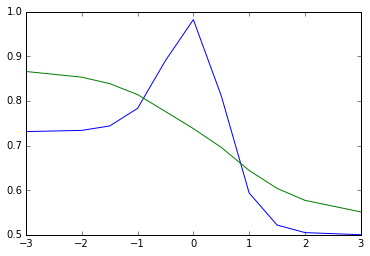

In [127]:
plt.plot(xs, ys, label = 'Esperado')

plt.plot(xs,y_predicted, label = 'Prediccion')
plt.legend()
plt.show()

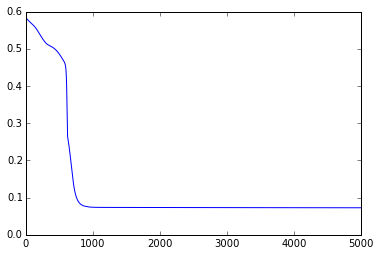

In [128]:
plt.plot(np.arange(len(errors)), errors)

El siguiente paso es buscar una semilla W que tenga, despues de entrenada, el mejor error. Para esto se calculan varias semillas aleatorias y la primera que despues de ser entrenada tenga un error menor a 0.05 se toma para la prediccion.

In [339]:
while True:
    w0 = np.random.uniform(0,10,(5,5))
    w0 = clean_w(w0)
    w_trained, errors = train_network(w0, w_edges, xs, ys, 5000) 
    
    print "nope",
    if errors[-1] < .05:
        print "YAAY! ", errors[-1]
        break
        
y_predicted = [evaluate_network(w_trained, xs[v] )[1][0] for v in xrange(len(xs))]

nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
nope
YAAY!  0.0211297102008


In [355]:
print w_trained


[[ 0.          0.          0.          0.          0.        ]
 [-2.43080652  0.          0.          0.          0.        ]
 [ 3.75898224  3.87792224  0.          0.          0.        ]
 [ 2.26104491 -4.4798474   0.          0.          0.        ]
 [ 0.          0.          7.53881513 -0.10641718  0.        ]]


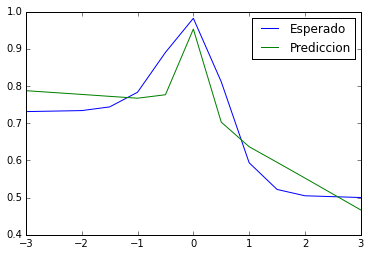

In [345]:
plt.plot(xs, ys, label='Esperado')
#y_predicted = y_predicted[::-1]
#xs = xs[::-1]
plt.plot(xs,y_predicted, label='Prediccion')
plt.legend()
plt.show()

Error 0.0211297102008


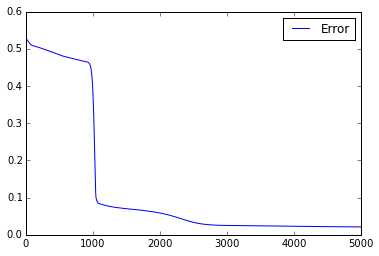

In [351]:
print "Error", errors[-1]
plt.plot(np.arange(len(errors)), errors, label = 'Error')
plt.legend()
plt.show()

Ahora se busca de nuevo una semilla w con la que se tenga un error menor a 0.05. Pero esta vez se modifica la funcion train_network haciendo que le detal varie el funcion de la cantidad de iteraciones. Se puede ver la solucion se encontro mas rapido y que la prediccion es mucho mas aproximada.

In [171]:
while True:
    w0 = np.random.uniform(0,10,(5,5))
    w0 = clean_w(w0)
    w_trained, errors = train_network(w0, w_edges, xs, ys, 5000) 
    
    print "nope",
    if errors[-1] < .05:
        print "YAAY! ", errors[-1]
        break
        
y_predicted = [evaluate_network(w_trained, xs[v] )[1][0] for v in xrange(len(xs))]

nope nope nope nope nope nope nope YAAY!  0.00227705417845


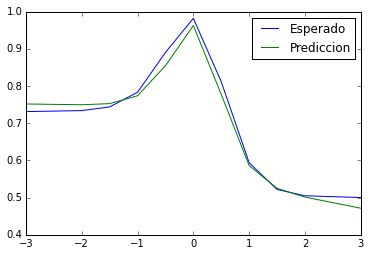

In [172]:
plt.plot(xs, ys, label='Esperado')
#y_predicted = y_predicted[::-1]
#xs = xs[::-1]
plt.plot(xs,y_predicted, label='Prediccion')
plt.legend()
plt.show()

Error 0.00227705417845


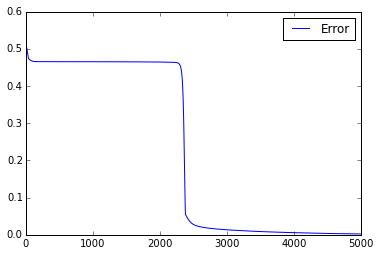

In [173]:
print "Error", errors[-1]
plt.plot(np.arange(len(errors)), errors, label = 'Error')
plt.legend()
plt.show()

###E - Data set largo

A continuacion se procede a leer los datos y crear los vectores x y y que describen mejor la grafica

In [18]:
data = open("datos1.txt")

lines = data.read().splitlines()

x_data = []
y_data = []
for line in lines:
    x_data.append( float (line.split()[0]))
    y_data.append( float (line.split()[1]))

x_data = np.array(x_data)
y_data = np.array(y_data)



Una vez los datos son leidos, se procede a hacer el entrenamiento y prediccion de la red. Para este caso se crea una nueva matriz w aleatoria. Se realizaron 10000 iteraciones y en la funcion train_network el delta variaba a razon del numero de iteraciones.

In [120]:
w1 = np.random.uniform(0,10,(5,5))
tam_w = len(w1)

for kk in xrange(tam_w):
    for jj in xrange(tam_w):

        w1[kk][jj] = w_edges[kk][jj] * w1[kk][jj]



w_trained_large, errors_large = train_network(w1, w_edges, x_data, y_data, 10000)
    #print w0

y_predicted_data = [evaluate_network(w_trained_large, x_data[v])[1][0] for v in xrange(len(x_data))] 


In [136]:
print "Matriz w resultante del entrenamiento"
print w_trained_large

Matriz w resultante del entrenamiento
[[ 0.          0.          0.          0.          0.        ]
 [-2.37899441  0.          0.          0.          0.        ]
 [-0.00760057 -3.18843687  0.          0.          0.        ]
 [ 7.13097545  2.51923356  0.          0.          0.        ]
 [ 0.          0.          3.14622056 -2.79046979  0.        ]]


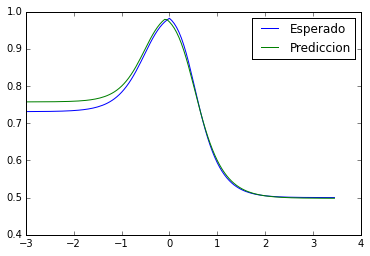

In [139]:
plt.plot(x_data, y_data, label='Esperado')
#y_predicted = y_predicted[::-1]
#xs = xs[::-1]
plt.plot(x_data,y_predicted_data, label='Prediccion')

plt.legend()
plt.show()


Error: 0.00973813203291


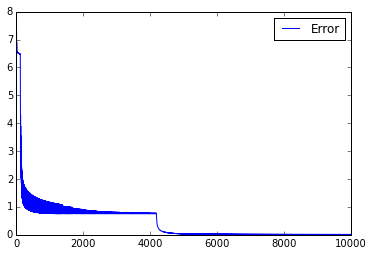

In [122]:
print "Error:", errors_large[-1]
plt.plot(np.arange(len(errors_large)), errors_large, label ='Error')
plt.legend()
plt.show()


Para este caso se observa que hasta la iteracion 4000 el error se encontraba en un optimo local, y que una vez superado el nuevo error hizo que la prediccion fuera muy buena. 

Ahora, igual que con el primer set de datos, se va a buscar una semilla w aleatoria que tenga el menor error posible. Para esto se van a hacer maximo 10 busquedas cada una con 10000 iteraciones. De nuevo se maneja en la funcion train_network un delta que varia segun el numero de iteraciones. 

In [174]:
itera = 0
while itera < 10:
    w1 = np.random.uniform(0,7,(5,5))
    w1 = clean_w(w1)
    w_trained_large, errors_large = train_network(w1, w_edges, x_data, y_data, 10000) 
    
    print "nope",
    if errors_large[-1] < .05:
        print "YAAY! ", errors_large[-1]
        break
    itera += 1    
y_predicted_large = [evaluate_network(w_trained_large, x_data[v] )[1][0] for v in xrange(len(x_data))]

nope nope YAAY!  0.00901325981981


In [176]:
print "La matriz W de pesos fue"
print w_trained

La matriz W de pesos fue
[[ 0.          0.          0.          0.          0.        ]
 [-3.65036747  0.          0.          0.          0.        ]
 [ 4.37994723  3.0473908   0.          0.          0.        ]
 [ 2.11338789 -3.23595748  0.          0.          0.        ]
 [ 0.          0.          3.29825259 -0.0319528   0.        ]]


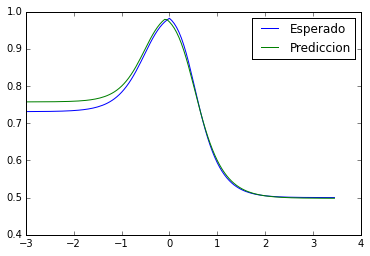

In [175]:
plt.plot(x_data, y_data, label='Esperado')
#y_predicted = y_predicted[::-1]
#xs = xs[::-1]
plt.plot(x_data,y_predicted_data, label='Prediccion')

plt.legend()
plt.show()

Error: 0.00901325981981


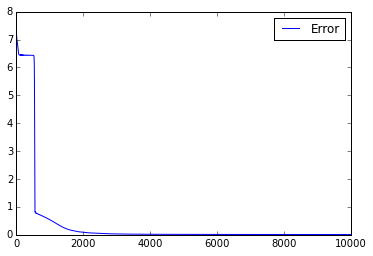

In [177]:
print "Error:", errors_large[-1]
plt.plot(np.arange(len(errors_large)), errors_large, label ='Error')
plt.legend()
plt.show()